# Outlier observation identification / testing

In [142]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         compute_corrected_ew_col,
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
import datetime as dt
pd.set_option('display.max_rows', None)

In [143]:
# Define functions to process data

def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed EQX OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Unique observation names:', len(obsdata))
    print()
    
    return obsdata

def remove_outliers(obsdata, outlier_obs):
    #remove 3 outliers from ~phase 50-60 before fitting for tau
    #(located by hand, removing from all 3 by observation name)
    
    for obsid in outlier_obs:
        #drop row containing outlier ob
        obsdata = obsdata[obsdata.index != obsid]
            
    print('Removed outlier OBSIDs:', outlier_obs)
    print('Unique observation names:', len(obsdata))
    print()
    return obsdata

def phase_curve(hg_used_data, low_ei_data, phase_col, uc_ew_col, ew_col):
    
    a=0.7
    ms=20
    
    plt.figure(figsize=(10,3))

    #plot the uncorrected points
    plt.subplot(1, 2, 1)
    plt.scatter(hg_used_data[phase_col], hg_used_data[uc_ew_col], c='midnightblue', alpha=a, s=ms)
    plt.scatter(low_ei_data[phase_col], low_ei_data[uc_ew_col], c='red', alpha=a, s=ms)
    plt.xlabel('Phase Angle (°)')
    plt.ylabel('Normal EW')
    plt.title('Normal EW vs. Phase Angle (uncorrected)')

    #plot the corrected points + model
    plt.subplot(1, 2, 2)
    plt.scatter(hg_used_data[phase_col], hg_used_data[ew_col], c='midnightblue', alpha=a, s=ms)
    plt.scatter(low_ei_data[phase_col], low_ei_data[ew_col], c='red', alpha=a, s=ms)
    plt.xlabel('Phase Angle (°)')
    plt.ylabel('Normal EW')
    plt.title(f'Normal EW vs. Phase Angle (corrected)')
    plt.show()

In [144]:
# Define variables

# directory of dumped EW csv files
dump_ew_dir = '/Users/mlessard/REU_2022/data/dump_ew_csv/'

#use all 3 regions, 4 boundaries between the regions
radii = ['139470', '140170', '140265', '140965']

size = '0' #slice/step size of the csv file

#degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

#define nstd for the HG param method
nstd = None

#remove outliers? (applies to both low-phase and HG param method)
rm_outliers = True

#list outlier obsids 
outliers = ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME'] #3 w/high EW for low-phase, corrected (~50-60)
outliers = outliers + ['ISS_041RF_FMOVIE002_VIMS', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_039RF_FMOVIE001_VIMS'] #105 outliers
outliers = outliers + ['ISS_041RF_FMOVIE001_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS'] #85 outliers
#"spike" outliers for 1-degree HG param phase curve:
#outliers = outliers + ['ISS_036RF_FMOVIE001_VIMS']  #160 phase spike
#outliers = outliers + ['ISS_196RF_FMOVIE006_PRIME'] #150 phase spike
#outliers = outliers + ['ISS_039RF_FMOVIE002_VIMS']  #~130 phase spike
#outliers = outliers + ['ISS_036RF_FMOVIE002_VIMS','ISS_196RF_FMOVIE005_PRIME'] #130-133 phase spike 

In [145]:
#get the full-width image data
full_img_filepath = f'{dump_ew_dir}ew_stats_widths_{radii[0]}_{radii[1]}_{radii[2]}_{radii[3]}_{size}.csv'
full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date'], index_col='Observation'); ms=20; alpha=0.7

#calculate mu, mu0 
full_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(full_orig_obsdata['Mean Emission'])))
full_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(full_orig_obsdata['Incidence'])))

In [146]:
#print initial statistics
print('** SUMMARY STATISTICS **')
print('Unique observation names:', len(full_orig_obsdata.groupby('Observation')))
print('Total slices:', len(full_orig_obsdata))
print('Starting date:', full_orig_obsdata['Date'].min())
print('Ending date:', full_orig_obsdata['Date'].max())
print('Time span:', full_orig_obsdata['Date'].max()-full_orig_obsdata['Date'].min())
print()

print(full_img_filepath)
print()

** SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

/Users/mlessard/REU_2022/data/dump_ew_csv/ew_stats_widths_139470_140170_140265_140965_0.csv



In [147]:
#remove EQX observations
removed_eqx_obsdata = remove_eqx(full_orig_obsdata, eqx_cutoff)

if rm_outliers:    
    #remove outliers
    obsdata = remove_outliers(removed_eqx_obsdata, outliers)
else:
    obsdata = removed_eqx_obsdata

Removed EQX OBSIDs: {'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME'}
Unique observation names: 145

Removed outlier OBSIDs: ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME', 'ISS_041RF_FMOVIE002_VIMS', 'ISS_108RF_FMOVIE001_PRIME', 'ISS_039RF_FMOVIE001_VIMS', 'ISS_041RF_FMOVIE001_VIMS', 'ISS_043RF_FMOVIE001_VIMS', 'ISS_044RF_FMOVIE001_VIMS']
Unique observation names: 136



In [148]:
# Find "small" (<6) e or i
low_phase_mask = obsdata['Mean Phase'] <= 60
low_phase_obsdata = obsdata[low_phase_mask]
lp_low_e_mask = np.abs(low_phase_obsdata['Mean Emission']-90) < 6
lp_low_i_mask = np.abs(low_phase_obsdata['Incidence']-90) < 6
lp_low_ei_mask = lp_low_e_mask | lp_low_i_mask

low_e_mask = np.abs(obsdata['Mean Emission']-90) < 6
low_i_mask = np.abs(obsdata['Incidence']-90) < 6
low_ei_mask = low_e_mask | low_i_mask

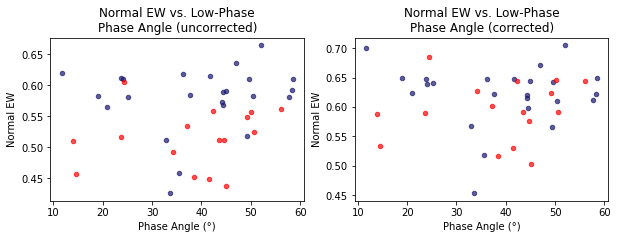

In [149]:
# Plot low-phase 3-zone Normal EW data
plt.figure(figsize=(10,3))

#plot the uncorrected points
plt.subplot(1, 2, 1)
plt.scatter(low_phase_obsdata['Mean Phase'][~lp_low_ei_mask], low_phase_obsdata['Normal EW'][~lp_low_ei_mask], \
                c='midnightblue', alpha=0.7, s=20)
plt.scatter(low_phase_obsdata['Mean Phase'][lp_low_ei_mask], low_phase_obsdata['Normal EW'][lp_low_ei_mask], \
                c='red', alpha=0.7, s=20)
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Low-Phase\nPhase Angle (uncorrected)')

#plot the corrected points + model
plt.subplot(1, 2, 2)
plt.scatter(low_phase_obsdata['Mean Phase'][~lp_low_ei_mask], low_phase_obsdata['Normal EW3Z'][~lp_low_ei_mask], \
                c='midnightblue', alpha=0.7, s=20)
plt.scatter(low_phase_obsdata['Mean Phase'][lp_low_ei_mask], low_phase_obsdata['Normal EW3Z'][lp_low_ei_mask], \
                c='red', alpha=0.7, s=20)
    
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Low-Phase\nPhase Angle (corrected)')
plt.show()

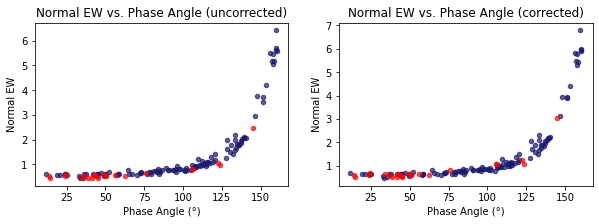

In [150]:
# Plot pre-calculated 3-zone Normal EW data
phase_curve(obsdata[~low_ei_mask], obsdata[low_ei_mask], phase_col='Mean Phase', uc_ew_col='Normal EW',\
            ew_col='Normal EW3Z')